<a href="https://colab.research.google.com/github/Grantar-alt/evol_methods/blob/main/base_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

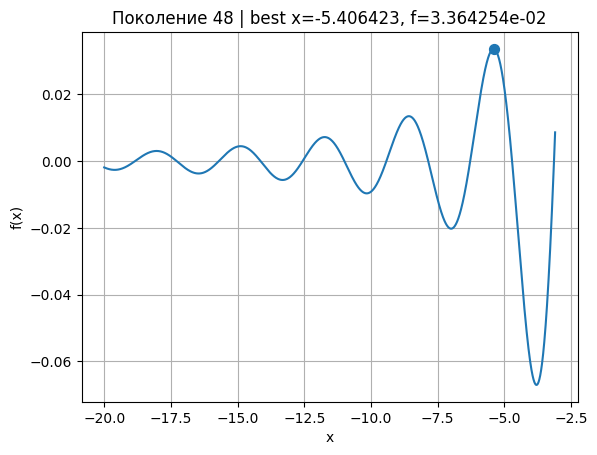

ИТОГ:
      best_x: -5.406423098013972
      best_f: 0.03364254013907153
 generations: 48
    time_sec: 17.559824516000006
      x_true: -5.406318425273701
      f_true: 0.03364254062752799
       err_x: 0.00010467274027092799
       err_f: 4.884564627771759e-10


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# =========================
# 1) Индивидуальное задание
# =========================
A, B = -20.0, -3.1  # интервал (вариант 4)
def f(x: np.ndarray) -> np.ndarray:
    # x не содержит 0, но на всякий случай защищаемся
    x = np.asarray(x, dtype=float)
    return np.sin(2.0 * x) / (x**2 + 1e-18)

# ==========================================================
# 2) Двоичное кодирование: битовая строка -> вещественное x
# ==========================================================
def bits_to_int(bits: np.ndarray) -> np.ndarray:
    # bits: (N, L) из 0/1
    L = bits.shape[1]
    weights = (1 << np.arange(L-1, -1, -1, dtype=np.uint64))  # 2^(L-1) ... 2^0
    return (bits * weights).sum(axis=1).astype(np.uint64)

def decode(bits: np.ndarray, a: float, b: float) -> np.ndarray:
    L = bits.shape[1]
    m = (1 << L) - 1  # 2^L - 1
    ints = bits_to_int(bits).astype(np.float64)
    return a + (ints / m) * (b - a)

# ==========================================================
# 3) Оператор репродукции: рулетка (пропорциональный отбор)
# ==========================================================
def roulette_selection(rng: np.random.Generator, fitness: np.ndarray, n_select: int) -> np.ndarray:
    # roulette требует неотрицательные значения
    fit = fitness.copy()
    fit -= fit.min()
    fit += 1e-12  # чтобы суммы/вероятности не обнулились
    p = fit / fit.sum()
    return rng.choice(len(fitness), size=n_select, replace=True, p=p)

# ==========================================================
# 4) Операторы кроссинговера и мутации
# ==========================================================
def one_point_crossover(rng: np.random.Generator, p1: np.ndarray, p2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # p1, p2: (L,)
    L = p1.shape[0]
    k = rng.integers(1, L)  # точка разрыва: 1..L-1
    c1 = np.concatenate([p1[:k], p2[k:]])
    c2 = np.concatenate([p2[:k], p1[k:]])
    return c1, c2

def mutate_bitflip(rng: np.random.Generator, child: np.ndarray, pm: float) -> np.ndarray:
    # инверсия бита с вероятностью pm
    mask = rng.random(child.shape[0]) < pm
    child = child.copy()
    child[mask] = 1 - child[mask]
    return child

# ==========================================================
# 5) Простой ГА (с расширением+редукцией = элитистский отбор лучших)
# ==========================================================
def simple_ga(
    *,
    seed: int = 42,
    L: int = 20,            # длина хромосомы (бит)
    N: int = 80,            # мощность популяции
    Pc: float = 0.85,       # вероятность кроссинговера
    Pm: float = 0.001,      # вероятность мутации (на бит)
    max_gen: int = 200,
    stall_gen: int = 30,    # ранняя остановка: сколько поколений нет улучшения
    plot_each_gen: bool = True,
):
    rng = np.random.default_rng(seed)

    # начальная популяция: (N, L)
    pop = rng.integers(0, 2, size=(N, L), dtype=np.int8)

    # для "действительного" решения сделаем плотный поиск (эталон)
    grid = np.linspace(A, B, 250_000)
    y_grid = f(grid)
    true_idx = int(np.argmax(y_grid))
    x_true, f_true = float(grid[true_idx]), float(y_grid[true_idx])

    best_f = -np.inf
    best_x = None
    best_bits = None
    best_hist = []
    t0 = time.perf_counter()

    no_improve = 0

    # подготовим график функции для отрисовки
    if plot_each_gen:
        xg = np.linspace(A, B, 2000)
        yg = f(xg)

    for gen in range(1, max_gen + 1):
        # фенотипы и целевая функция
        xs = decode(pop, A, B)
        ys = f(xs)  # так как максимум

        # фиксируем лучшее
        idx = int(np.argmax(ys))
        if ys[idx] > best_f + 1e-12:
            best_f = float(ys[idx])
            best_x = float(xs[idx])
            best_bits = pop[idx].copy()
            no_improve = 0
        else:
            no_improve += 1

        best_hist.append(best_f)

        # визуализация: функция + лучшая точка на текущем поколении
        if plot_each_gen:
            clear_output(wait=True)
            plt.figure()
            plt.plot(xg, yg)
            plt.scatter([best_x], [best_f], s=50)
            plt.title(f"Поколение {gen} | best x={best_x:.6f}, f={best_f:.6e}")
            plt.xlabel("x")
            plt.ylabel("f(x)")
            plt.grid(True)
            plt.show()

        # критерий ранней остановки
        if no_improve >= stall_gen:
            break

        # ----------- Эволюционные операторы -----------
        # 1) Репродукция (рулетка) -> выбираем родителей
        parent_idx = roulette_selection(rng, ys, N)
        parents = pop[parent_idx]

        # 2) Кроссинговер+мутация -> формируем потомков
        children = []
        for i in range(0, N, 2):
            p1 = parents[i]
            p2 = parents[(i + 1) % N]
            if rng.random() < Pc:
                c1, c2 = one_point_crossover(rng, p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            c1 = mutate_bitflip(rng, c1, Pm)
            c2 = mutate_bitflip(rng, c2, Pm)
            children.append(c1)
            children.append(c2)
        children = np.asarray(children[:N], dtype=np.int8)

        # 3) Расширение + редукция: объединяем pop и children, оставляем лучших N
        combined = np.vstack([pop, children])
        x_comb = decode(combined, A, B)
        y_comb = f(x_comb)
        best_idx = np.argsort(-y_comb)[:N]  # сортировка по убыванию
        pop = combined[best_idx]

    elapsed = time.perf_counter() - t0

    # итоговая точность относительно "действительного" решения
    err_x = abs(best_x - x_true)
    err_f = abs(best_f - f_true)

    result = {
        "best_x": best_x,
        "best_f": best_f,
        "best_bits": best_bits,
        "generations": gen,
        "time_sec": elapsed,
        "x_true": x_true,
        "f_true": f_true,
        "err_x": err_x,
        "err_f": err_f,
        "history_best_f": np.array(best_hist, dtype=float),
    }
    return result

res = simple_ga(
    seed=1,
    L=20,
    N=80,
    Pc=0.85,
    Pm=0.001,
    max_gen=200,
    stall_gen=30,
    plot_each_gen=True
)

print("ИТОГ:")
for k in ["best_x","best_f","generations","time_sec","x_true","f_true","err_x","err_f"]:
    print(f"{k:>12}: {res[k]}")
